# Decision trees and Random Forests

## Decision Trees
The goal of a decision tree is to create a model that predicts the value of a target variable based on several input variables. Each interior node corresponds to one of the input variables. Each leaf represents a value of the target variable given the values of the input variables represented by the path from the root to the leaf.

In [66]:
import pandas as pd
%matplotlib inline
datafile = '~/databases/titanic/train.csv'
titanic = pd.read_csv(datafile)
titanic[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


#### Some Vocab
* **Class**: Each element of the domain of the classification. 
    * example: Survived, died
* **Feature**:  
    * example: age, sibsp, sex
* **Node**: Each node is labeled with a feature. The arcs coming from a node labeled with a feature are labeled with each of the possible values of the feature.
* **Classification And Regression Tree (CART)** is a general name for decision trees.



![decision-tree example](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

### Types of Decision trees
* **Classification tree** analysis is when the predicted outcome is the class to which the data belongs.
* **Regression tree** analysis is when the predicted outcome can be considered a real number (e.g. the price of a house, or a patient’s length of stay in a hospital).

#### Attributes of Decision Trees
* Low bias
* High variance
* Prone to overfitting

![biasvsvariance](http://www.mdpi.com/entropy/entropy-16-05242/article_deploy/html/images/entropy-16-05242f6-1024.png)

### Why Random Forests?
* Few tuning parameters
* Good performance
* Easy to use
* Don't need to standardize training data
* Automatically quantifies the importance of each feature for you.
* An ensemble learning method
    * Taking multiple learning methods and aggregating their results


### Random Forests
* A random forest is simply, a collection of decision trees.
* Random Forests operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 
* Random decision forests correct for decision trees' habit of overfitting to their training set.  
* In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, because they have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance.This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.  

#### Bootstrap Aggregating (Tree bagging)
The training algorithm for random forests applies the general technique of **bootstrap aggregating**, or bagging, to tree learners.  

This will reduce the variance without increasing bias!  
This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly (B times) selects a random sample with replacement of the training set and fits trees to these samples

For $b = 1, ..., B$:
1. Sample, with replacement, $n$ training examples from $X$, $Y$; call these $X_b, Y_b$.
2. Train a decision or regression tree $f_b$ on $X_b, Y_b$.

After training, predictions for unseen samples $x'$ can be made by averaging the predictions from all the individual regression trees on $x'$:

$\hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x')$

or by taking the majority vote in the case of decision trees.  
.  
.  

Given a new data point, we will run it through each decision tree in the forest and record how many trees vote for it to be a dead (blue) and how many vote for it to be alive (green). Whichever color gets the most votes, that’s the decision that the random forest makes. 

![combining trees](https://shapeofdata.files.wordpress.com/2013/07/randforest.png)

The distributions defined by two decision trees are shown on the left and middle. The final distribution, shown on the right, comes from super-imposing the decision boundaries of the two individual trees. Each region in the resulting distribution is colored green if it is contained in green regions in both of the original two trees. It’s colored blue if it is contained in two blue regions, and grey if it is in one of each. These grey regions are ties.  
.  
.  

##### Tuning Parameters
1. Number of trees $B$
    * More is better
    * Diminishing returns
    * Slower 
    * Typically, a few hundred to several thousand trees are used, depending on the size and nature of the training set. An optimal number of trees $B$ can be found using cross-validation, or by observing the 'out-of-bag error': the mean prediction error on each training sample $x_i$, using only the trees that did not have $x_i$ in their bootstrap sample. The training and test error tend to level off after some number of trees have been fit.
    * Too few trees, and not all samples will be accounted for
2. Number of features
    * Just like we randomly selected datapoints to create our trees, we will also randomly select the features used to make each tree.
    * This decreases correlation between each tree. (same features $->$ same results) 
    * Typically, for a classification problem with p features, $\sqrt{p}$ (rounded down) features are used in each split. For regression problems the inventors recommend p/3 (rounded down) with a minimum node size of 5 as the default.
3. Depth of trees
    * If you go to deep, you risk overfitting the data
    * It's hard to know ahead of time how deep the trees are and what limit to place.

## Using sklearn's Random forest

##### Get our data and format it a little bit

In [27]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [28]:
def format_titanic_data(trainfile,testfile,predictors):
    titanic = pd.read_csv(trainfile)
    test = pd.read_csv(testfile)
    '''convert data to usable values'''
    for data in [titanic,test]:
        #replace Sex with numbers
        data.loc[data.Sex=='male','Sex']  = 0
        data.loc[data.Sex=='female','Sex']= 1
        #replace Embarked values with numbers
        data.Embarked = data.Embarked.fillna('S')
        data.loc[data.Embarked == 'S', 'Embarked']    =0
        data.loc[data.Embarked == 'C', 'Embarked']    =1
        data.loc[data.Embarked == 'Q', 'Embarked']    =2
    
    for field in predictors:
        titanic[field] = titanic[field].fillna(titanic[field].median())
        test[field] = test[field].fillna(titanic[field].median())
    return titanic, test
trainfile = '~/databases/titanic/train.csv'
testfile = '~/databases/titanic/test.csv'
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic,test = format_titanic_data(trainfile,testfile,predictors)

##### Imputation
* Filling in missing values
* Median is usually used for decision trees
* Column missing entirely?
    * Fill all the nans uniformly. (example is all zeros)
    * Because there is no variance in this column, it will never be chosen in the decision trees
    

In [29]:
#sklearn can do it just like pandas can! but only if data is all numbers
def imputation_with_sklearn():
    from sklearn.preprocessing import Imputer
    imp = Imputer(strategy='median')
    imp.fit(titanic)
    imputed_train = imp.transform(titanic)
    #remember, you need to use the median of the training data, not the test data
    imputed_test= imp.transform(test)


In [30]:
#what if features are missing entirely?
def missing_column_example():
    mask = np.all(np.isnan(train),axis=0)
    train[:,mask] = 0.0

#### Implement random forest algorithm

In [31]:
#%%timeit
alg = RandomForestClassifier(random_state=1, 
                             n_estimators=150,           #number of trees
                             max_features='auto',        #number of features to consider at each split
                             max_depth = None,           #depth of tree if known      
                             min_samples_split=4,        #tree won't split unless at least this many samples in each branch
                             min_samples_leaf=2,         #tree won't split unless at least this many samples in each leaf
                             min_weight_fraction_leaf=0, #similar to min_samples_leaf except comparative
                             max_leaf_nodes=None,        #contraining the depth by limiting the number of leaves
                             n_jobs=4)                   #number of cores to use in calculation. default = 1, -1 means use all cores
predictions = cross_validation.cross_val_predict(alg, 
                                                 titanic[predictors], 
                                                 titanic["Survived"], 
                                                 cv=3)
scores = cross_validation.cross_val_score(alg, 
                                          titanic[predictors], 
                                          titanic["Survived"], 
                                          cv=3, 
                                          scoring ='accuracy' )
print np.mean(scores)

0.820426487093


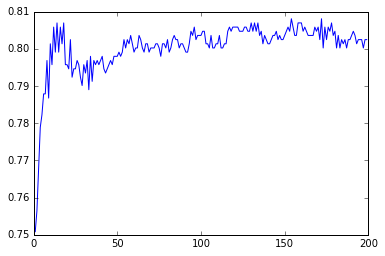

In [32]:
#lets play around with our number of trees
trees = range(1,200)
allscores = []
for i in trees:
    
    alg = RandomForestClassifier(random_state=1, 
                                 n_estimators=i)
    predictions = cross_validation.cross_val_predict(alg, 
                                                     titanic[predictors], 
                                                     titanic["Survived"], 
                                                     cv=3)
    scores = cross_validation.cross_val_score(alg, 
                                              titanic[predictors], 
                                              titanic["Survived"], 
                                              cv=3, 
                                              scoring ='accuracy' )
    allscores.append(np.mean(scores))
plt.plot(trees,allscores)
plt.show()

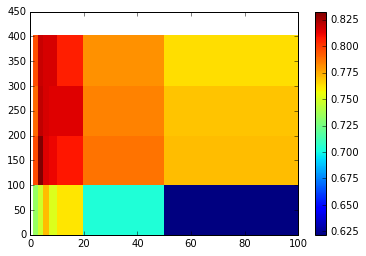

In [26]:
#lets play around with our number of trees and min leaf size
trees = range(1,501,100)
minsampleleafs= [1,3,5,7,10,20,50,100]
allscores = np.zeros((len(trees),len(minsampleleafs)))
for i,tree in enumerate(trees):
    for j,leaf in enumerate(minsampleleafs):
        alg = RandomForestClassifier(min_samples_leaf=leaf,   
                                     n_estimators=tree)
        predictions = cross_validation.cross_val_predict(alg, 
                                                         titanic[predictors], 
                                                         titanic["Survived"], 
                                                         cv=3)
        scores = cross_validation.cross_val_score(alg, 
                                                  titanic[predictors], 
                                                  titanic["Survived"], 
                                                  cv=3, 
                                                  scoring ='accuracy' )
        allscores[i,j]=np.mean(scores)
plt.pcolormesh(minsampleleafs,trees,allscores)
plt.colorbar()
plt.show()

In [80]:
alg.fit(titanic[predictors],
        titanic["Survived"])
prediction = alg.predict(test[predictors])
print prediction

#save it 
submission = pd.DataFrame({ "Survived": prediction,"PassengerId":test.PassengerId})
submission.to_csv('~/databases/titanic/submission_rf1',index=False)
print submission[:10]

[0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 0 0 1]
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         0
5

### Feature Importances
* The closer to the root a feature is, the more important it is in predicting. sklearn has a built in method for finding the average importance of a feature.

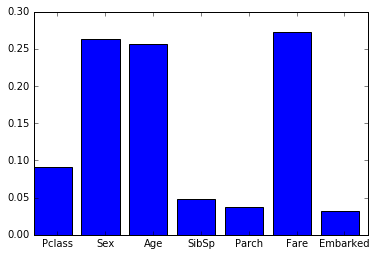

In [91]:
plt.bar(np.arange(len(predictors)),alg.feature_importances_,tick_label=predictors)
plt.xticks(np.arange(len(predictors))+.5)
plt.show()

##### Sources
https://shapeofdata.wordpress.com/2013/07/09/random-forests/
https://en.wikipedia.org/wiki/Random_forest#Preliminaries:_decision_tree_learning  
https://www.dataquest.io/mission/75/improving-your-submission